# Project #2 — Diabetes Prediction
Author: Isabel Ekwenibe GitHub Repository Link: https://github.com/ne00040/Diabetes-Prediction-Analysis

## 1. Problem Statement

This project aims to predict whether an individual is likely to develop or has been diagnosed with diabetes based on various demographic, lifestyle, and clinical factors.  
The analysis will explore which features contribute most to predicting diabetes outcomes and how accurately machine learning models can make these predictions.


## 2. Dataset Overview

- **Total Records:** 100,000  
- **Total Features:** 31  
- **Feature Categories:**
  - **Demographic:** `age`, `gender`, `ethnicity`, `education_level`, `income_level`
  - **Lifestyle:** `physical_activity`, `smoking_status`, `diet_score`
  - **Clinical:** `bmi`, `blood_pressure`, `cholesterol`, `glucose_level`, `insulin_sensitivity`, `diabetes_risk_score`, `diabetes_stage`


## 3. Target Variable — `diagnosed_diabetes`
- **Type:** Binary classification  
- **Values:**
  - `1` → Diagnosed with diabetes  
  - `0` → Not diagnosed  


## 4. Prediction Goal
Build and evaluate a **classification model** that predicts whether a person is **diagnosed with diabetes** (`1`) or **not** (`0`) based on their **health and lifestyle indicators**.

In [205]:
## 2. Data Cleaning
### Load the dataset, check its size, column names and data types
import pandas as pd
import numpy as np

df = pd.read_csv("diabetes_dataset.csv")

print("Dataset shape:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
print("\nData types:\n")
print(df.dtypes)

Dataset shape: (100000, 31)

Column names:
 ['age', 'gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score', 'diabetes_stage', 'diagnosed_diabetes']

Data types:

age                                     int64
gender                                 object
ethnicity                              object
education_level                        object
income_level                           object
employment_status                      object
smoking_status                         object
alcohol_consumption_

In [206]:
### Check for missing values and remove duplicate rows
print("\nMissing Values per Column:\n")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

df = df.drop_duplicates()
print("New shape after removing duplicates:", df.shape)


Missing Values per Column:

age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fas

In [207]:
### Check categorical variables for inconsistent inputs
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())


Unique values in 'gender':
['Male' 'Female' 'Other']

Unique values in 'ethnicity':
['Asian' 'White' 'Hispanic' 'Black' 'Other']

Unique values in 'education_level':
['Highschool' 'Graduate' 'Postgraduate' 'No formal']

Unique values in 'income_level':
['Lower-Middle' 'Middle' 'Low' 'Upper-Middle' 'High']

Unique values in 'employment_status':
['Employed' 'Unemployed' 'Retired' 'Student']

Unique values in 'smoking_status':
['Never' 'Former' 'Current']

Unique values in 'diabetes_stage':
['Type 2' 'No Diabetes' 'Pre-Diabetes' 'Gestational' 'Type 1']


In [208]:
### Fix inconsistent text formatting
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

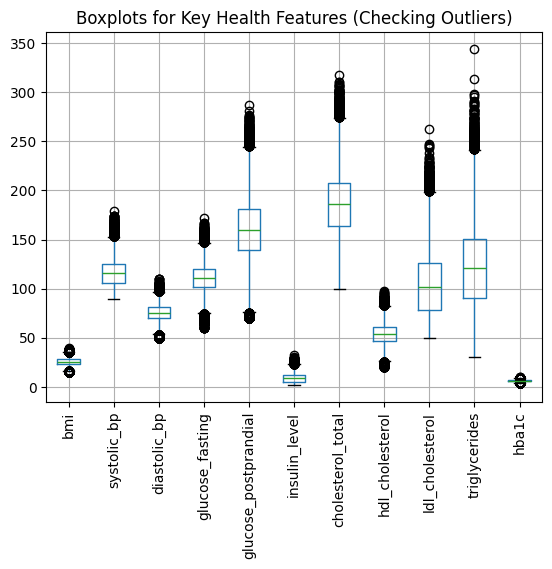

In [209]:
### Detect outliers using boxplots
import matplotlib.pyplot as plt

num_cols = [
    'bmi', 'systolic_bp', 'diastolic_bp', 'glucose_fasting',
    'glucose_postprandial', 'insulin_level', 'cholesterol_total',
    'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'hba1c'
]

df.boxplot(column=num_cols)
plt.title("Boxplots for Key Health Features (Checking Outliers)")
plt.xticks(rotation=90)
plt.show()

In [210]:
### Remove outliers using Interquartile Range (IQR) method
def remove_outliers_iqr(data, cols):
    clean = data.copy()
    for col in cols:
        Q1 = clean[col].quantile(0.25)
        Q3 = clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        clean = clean[(clean[col] >= lower) & (clean[col] <= upper)]
    return clean

df = remove_outliers_iqr(df, num_cols)
print("Shape after removing outliers:", df.shape)

Shape after removing outliers: (94799, 31)


In [211]:
print("Final dataset shape:", df.shape)
print("Missing values left:", df.isnull().sum().sum())

Final dataset shape: (94799, 31)
Missing values left: 0


### Data Cleaning Summary
- Checked for missing values and duplicates.
- Cleaned categorical inputs and standardized text formatting.
- Converted categorical variables to numeric using one-hot encoding.
- Detected and removed outliers using the IQR method.

In [212]:
## 3. Feature Engineering
### Drop features that leak the target
df.columns = df.columns.str.strip().str.lower()

leakage_features = [
    'diabetes_risk_score', 'diabetes_stage', 'hba1c'
]
df = df.drop(columns=[col for col in leakage_features if col in df.columns], errors='ignore')

print("Columns after dropping leakage features:")
print(df.columns.tolist())

X = df.drop(columns=['diagnosed_diabetes'])
y = df['diagnosed_diabetes']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

X = pd.get_dummies(X, drop_first=True)
print("\nShape after one-hot encoding:", X.shape)

Columns after dropping leakage features:
['age', 'gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'diagnosed_diabetes']

Shape after one-hot encoding: (94799, 39)


In [213]:
### Check for Zero or Low Variance Features
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  
selector.fit(X)

low_variance = X.columns[~selector.get_support()]
print("Low or zero variance features:", low_variance.tolist())

X = X.drop(columns=low_variance)

Low or zero variance features: ['waist_to_hip_ratio']


In [214]:
### Use ANOVA Test for Numerical Features
from sklearn.feature_selection import f_classif
import pandas as pd

num_cols = X.select_dtypes(include=[np.number]).columns

f_values, p_values = f_classif(X[num_cols], y)

anova_results = pd.DataFrame({'Feature': num_cols, 'P-Value': p_values})
anova_results = anova_results.sort_values(by='P-Value')
display(anova_results)

significant_num = anova_results[anova_results['P-Value'] < 0.05]['Feature'].tolist()
print("Significant numerical features (p < 0.05):")
print(significant_num)

,Feature,P-Value
0,age,0.000000e+00
6,family_history_diabetes,0.000000e+00
18,glucose_postprandial,0.000000e+00
17,glucose_fasting,0.000000e+00
2,physical_activity_minutes_per_week,3.032723e-193
9,bmi,1.007229e-163
10,systolic_bp,1.390662e-159
15,ldl_cholesterol,2.812017e-77
13,cholesterol_total,2.675101e-58
19,insulin_level,1.347612e-55


Significant numerical features (p < 0.05):
['age', 'family_history_diabetes', 'glucose_postprandial', 'glucose_fasting', 'physical_activity_minutes_per_week', 'bmi', 'systolic_bp', 'ldl_cholesterol', 'cholesterol_total', 'insulin_level', 'triglycerides', 'hdl_cholesterol', 'diet_score', 'diastolic_bp', 'cardiovascular_history', 'hypertension_history', 'heart_rate', 'screen_time_hours_per_day']


In [215]:
### Use Chi-Squared Test for Categorical Features
from sklearn.feature_selection import chi2

cat_cols = [c for c in X.columns if c not in num_cols]

if len(cat_cols) > 0:
    chi_scores, p_vals = chi2(X[cat_cols], y)
    chi_results = pd.DataFrame({'Feature': cat_cols, 'P-Value': p_vals})
    chi_results = chi_results.sort_values(by='P-Value')
    display(chi_results)

    significant_cat = chi_results[chi_results['P-Value'] < 0.05]['Feature'].tolist()
    print("Significant categorical features (p < 0.05):")
    print(significant_cat)
else:
    significant_cat = []

,Feature,P-Value
1,gender_other,0.148320
8,education_level_postgraduate,0.171184
3,ethnicity_hispanic,0.178594
13,employment_status_retired,0.185127
4,ethnicity_other,0.189918
10,income_level_lower-middle,0.202868
11,income_level_middle,0.206747
7,education_level_no formal,0.580475
2,ethnicity_black,0.646586
14,employment_status_student,0.660512


Significant categorical features (p < 0.05):
[]


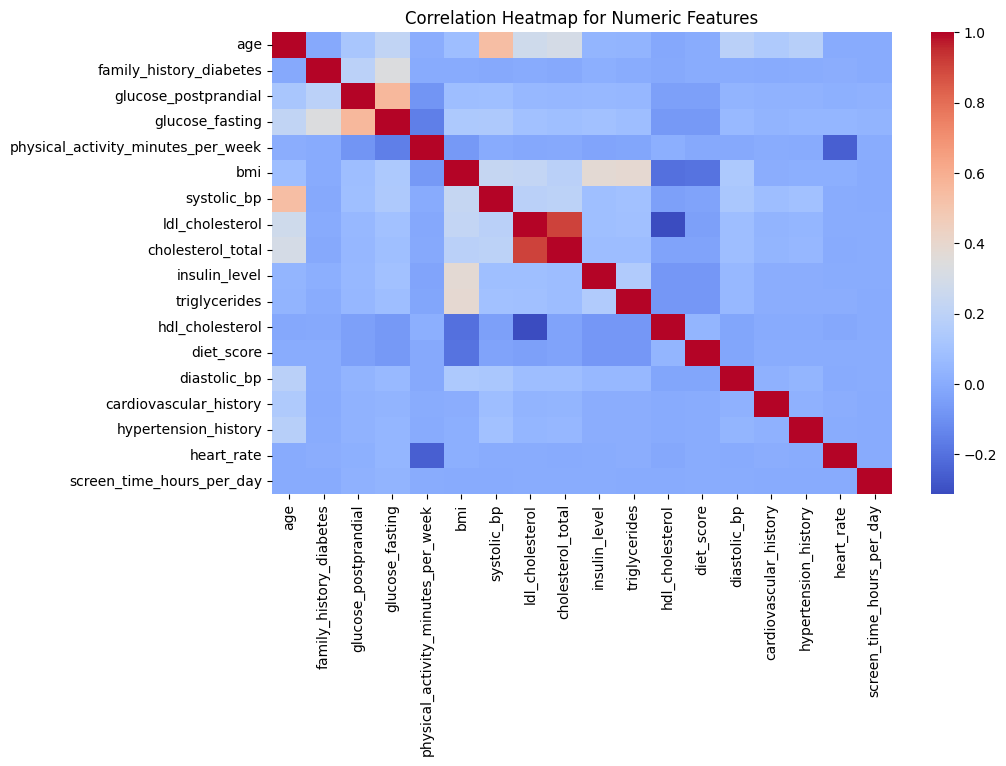

Dropping due to high correlation: {'cholesterol_total'}


In [216]:
### Correlation Analysis (Identify Highly Correlated Features)
import seaborn as sns

corr = X[significant_num].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

threshold = 0.9
to_drop = set()

for col in corr.columns:
    for row in corr.index:
        if col != row and corr.loc[col, row] > threshold:
            if row not in to_drop and col not in to_drop:
                to_drop.add(row)

print("Dropping due to high correlation:", to_drop)
X = X.drop(columns=list(to_drop), errors='ignore')

In [217]:
### Combine All Selected Features
selected_features = list(set(significant_num + significant_cat))
selected_features = [col for col in selected_features if col in X.columns]

X = X[selected_features]

print("Final selected features (after all filtering):")
print(X.columns.tolist())
print("\nTotal selected features:", len(X.columns))

Final selected features (after all filtering):
['glucose_postprandial', 'bmi', 'family_history_diabetes', 'age', 'ldl_cholesterol', 'triglycerides', 'diet_score', 'insulin_level', 'hypertension_history', 'screen_time_hours_per_day', 'glucose_fasting', 'cardiovascular_history', 'heart_rate', 'physical_activity_minutes_per_week', 'diastolic_bp', 'hdl_cholesterol', 'systolic_bp']

Total selected features: 17


In [218]:
### Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Scaled feature sample:")
print(X_scaled.head())

Scaled feature sample:
   glucose_postprandial       bmi  family_history_diabetes       age  \
0              0.952381  0.755208                      0.0  0.555556   
1              0.440476  0.369792                      0.0  0.416667   
2              0.708333  0.322917                      1.0  0.583333   
3              0.642857  0.270833                      0.0  0.388889   
4              0.339286  0.526042                      0.0  0.388889   

   ldl_cholesterol  triglycerides  diet_score  insulin_level  \
0         0.758621       0.545024        0.57       0.203738   
1         0.000000       0.000000        0.67       0.000000   
2         0.337931       0.028436        0.64       0.143458   
3         0.517241       0.616114        0.72       0.501869   
4         0.475862       0.706161        0.90       0.316355   

   hypertension_history  screen_time_hours_per_day  glucose_fasting  \
0                   0.0                   0.453988         0.847222   
1                

### Feature Engineering Summary
- Removed low-variance features using `VarianceThreshold`.
- Dropped leakage features (diabetes_stage, diabetes_risk_score, hba1c) to prevent overfitting.
- Applied ANOVA F-test for numerical features.
- Applied Chi-squared test for categorical features.
- Dropped highly correlated features using a correlation heatmap.
- Performed one-hot encoding for categorical variables before scaling.
- Combined selected features and scaled them using Min-Max normalization.

In [219]:
## 4. Build the Prediction Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Prepare the data
X = X_scaled
y = df['diagnosed_diabetes']

print("Target variable counts before balancing:")
print(y.value_counts())

# Step 2: Balance the data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("\nTarget variable counts after balancing:")
print(y_resampled.value_counts())

# Step 3: Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 4: Train the Logistic Regression model
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Target variable counts before balancing:
diagnosed_diabetes
1    56714
0    38085
Name: count, dtype: int64

Target variable counts after balancing:
diagnosed_diabetes
0    38085
1    38085
Name: count, dtype: int64

Model Evaluation Metrics:
Accuracy: 0.845
Precision: 0.845
Recall: 0.845
F1 Score: 0.845


**Interpretation:**

The logistic regression model achieved 84.5% accuracy with balanced precision and recall.
Using under-sampling effectively addressed class imbalance and reduced overfitting.
Removing leakage features like diabetes_stage improved model reliability.

### Model Building Summary
- Used `RandomUnderSampler` to balance the dataset.
- Split data using `train_test_split` (80/20).
- Trained a `LogisticRegression` model.
- Evaluated using accuracy, precision, recall, F1 score, confusion matrix, and classification report.